<a href="https://colab.research.google.com/github/priyankgupta2003/FacialExpressionClassifier/blob/main/FacialExpressionClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess the dataset
def load_and_preprocess_data(base_directory):
    categories = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    images = []
    labels = []

    for i, category in enumerate(categories):
        category_path = os.path.join(base_directory, category, '*.jpg')
        for img_path in glob.glob(category_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48))
            img = img[..., np.newaxis] / 255.0
            images.append(img)
            labels.append(i)

    images = np.array(images, dtype='float32')
    labels = to_categorical(labels)
    return images, labels

In [3]:
# Define the CNN model
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [5]:
# Load the datasets
train_directory = '/content/drive/MyDrive/data/images/train'
val_directory = '/content/drive/MyDrive/data/images/validation'
X_train_full, y_train_full = load_and_preprocess_data(train_directory)
X_val, y_val = load_and_preprocess_data(val_directory)

# Split the training data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [6]:
# Create the model
input_shape = (48, 48, 1)
num_classes = 7
model = create_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
#Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [8]:
# Train the model
epochs = 50
batch_size = 64
history = model.fit(data_gen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_val, y_val),
                    epochs=epochs)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')

Epoch 1/50
225/225 [==============================] - 84s 364ms/step - loss: 1.4914 - accuracy: 0.3224 - val_loss: 3.6764 - val_accuracy: 0.1739
Epoch 2/50
225/225 [==============================] - 78s 348ms/step - loss: 1.3177 - accuracy: 0.3617 - val_loss: 4.5194 - val_accuracy: 0.2546
Epoch 3/50
225/225 [==============================] - 80s 354ms/step - loss: 1.2526 - accuracy: 0.4121 - val_loss: 5.1204 - val_accuracy: 0.3104
Epoch 4/50
225/225 [==============================] - 81s 361ms/step - loss: 1.2040 - accuracy: 0.4354 - val_loss: 5.7002 - val_accuracy: 0.3493
Epoch 5/50
225/225 [==============================] - 80s 356ms/step - loss: 1.1580 - accuracy: 0.4730 - val_loss: 5.3503 - val_accuracy: 0.4007
Epoch 6/50
225/225 [==============================] - 79s 350ms/step - loss: 1.0955 - accuracy: 0.5104 - val_loss: 5.0127 - val_accuracy: 0.1664
Epoch 7/50
225/225 [==============================] - 79s 350ms/step - loss: 1.0512 - accuracy: 0.5326 - val_loss: 4.6635 - val_ac

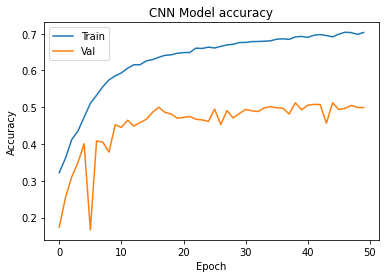

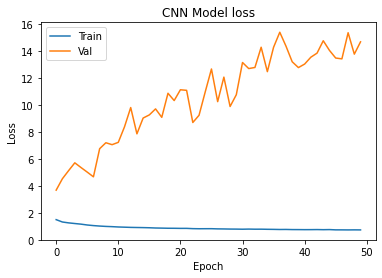

In [37]:
#plot the accuracy and loss curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [10]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model


In [11]:
def create_pretrained_model(input_shape, num_classes):
    # Convert grayscale input to RGB
    grayscale_input = Input(input_shape)
    rgb_input = tf.keras.layers.Concatenate(axis=-1)([grayscale_input, grayscale_input, grayscale_input])
    
    # Load the pre-trained MobileNetV2 model without the top layers
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=rgb_input)

    # Add the top layers for your classification task
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=grayscale_input, outputs=output)

    return model



In [12]:
# Create the pre-trained model
input_shape = (48, 48, 1)
num_classes = 7
pretrained_model = create_pretrained_model(input_shape, num_classes)
pretrained_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the pre-trained model
history_pretrained = pretrained_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

# Evaluate the pre-trained model on the test set
test_loss_pretrained, test_accuracy_pretrained = pretrained_model.evaluate(X_test, y_test)
print(f'Test accuracy (pre-trained model): {test_accuracy_pretrained}')


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/50
225/225 [==============================] - 216s 889ms/step - loss: 1.1172 - accuracy: 0.5367 - val_loss: 41.3613 - val_accuracy: 0.4233
Epoch 2/50
225/225 [==============================] - 204s 908ms/step - loss: 0.8017 - accuracy: 0.6778 - val_loss: 28.1168 - val_accuracy: 0.3745
Epoch 3/50
225/225 [==============================] - 205s 913ms/step - loss: 0.6782 - accuracy: 0.7261 - val_loss: 18.8584 - val_accuracy: 0.4471
Epoch 4/50
225/225 [==============================] - 208s 927ms/step - loss: 0.5961 - accuracy: 0.7628 - val_loss: 16.8836 - val_accuracy: 0.4769
Epoch 5/50
225/225 [==============================] - 205s 912ms/step - loss: 0.5414 - accuracy: 0.7850 - val_loss: 13.4615 - val_accuracy: 0.4761
Epoch 6/50
225/225 [==============================] - 195s 868ms/step - loss: 0.4966 - accuracy: 0.8030 - val_loss: 15.1890 - val_accuracy: 0.4333
Epoch 7/50
225/225 [==============================] - 2

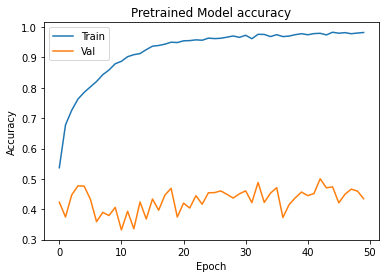

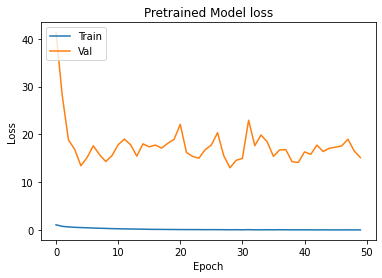

In [36]:
#plot the accuracy and loss curves
plt.plot(history_pretrained.history['accuracy'])
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('Pretrained Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history_pretrained.history['loss'])
plt.plot(history_pretrained.history['val_loss'])
plt.title('Pretrained Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [13]:
import numpy as np
from imblearn.over_sampling import RandomOverSampler

epochs = 20
batch_size = 64

# Flatten the images for the oversampling process
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

# Apply RandomOverSampler
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flattened, y_train.argmax(axis=1))

# Unflatten the images back to their original shape
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], 48, 48, 1)

# Convert y_train_resampled back to categorical
y_train_resampled = to_categorical(y_train_resampled)

# Train the model with the resampled data
history_sample = model.fit(data_gen.flow(X_train_resampled, y_train_resampled, batch_size=batch_size),
                    validation_data=(X_val, y_val),
                    epochs=epochs)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')


Epoch 1/20
252/252 [==============================] - 87s 347ms/step - loss: 0.7131 - accuracy: 0.7132 - val_loss: 14.8408 - val_accuracy: 0.4980
Epoch 2/20
252/252 [==============================] - 89s 352ms/step - loss: 0.7104 - accuracy: 0.7168 - val_loss: 13.9780 - val_accuracy: 0.4925
Epoch 3/20
252/252 [==============================] - 117s 465ms/step - loss: 0.7083 - accuracy: 0.7132 - val_loss: 15.3745 - val_accuracy: 0.4635
Epoch 4/20
252/252 [==============================] - 88s 351ms/step - loss: 0.7029 - accuracy: 0.7160 - val_loss: 15.2575 - val_accuracy: 0.4885
Epoch 5/20
252/252 [==============================] - 90s 357ms/step - loss: 0.7040 - accuracy: 0.7181 - val_loss: 15.5779 - val_accuracy: 0.4829
Epoch 6/20
252/252 [==============================] - 87s 344ms/step - loss: 0.6891 - accuracy: 0.7236 - val_loss: 15.9540 - val_accuracy: 0.5001
Epoch 7/20
252/252 [==============================] - 86s 343ms/step - loss: 0.6955 - accuracy: 0.7181 - val_loss: 14.9456 

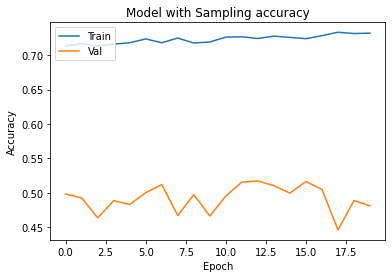

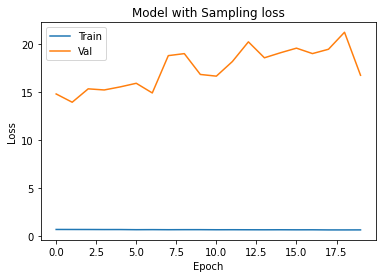

In [15]:
#plot the accuracy and loss curves
plt.plot(history_sample.history['accuracy'])
plt.plot(history_sample.history['val_accuracy'])
plt.title('Model with Sampling accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history_sample.history['loss'])
plt.plot(history_sample.history['val_loss'])
plt.title('Model with Sampling loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()